# Multi variate time series - anomaly detection

* There are 509k samples with 11 features
* Each instance / row is one moment in time. 
* I don't know what the time step is: 100 ms, 1ms, ?
* 443 rows are identified as events, basically rare, outliers / anomalies .. **0.09%** 


### Task is to identify these events in this time series - time series classification (not forecasting)

* As dataset is unbalanced, the metric to use is **F1 score** (not accuracy, nor ROC AUC)
* Initial approach for a baseline - NOT as a time series but as individual instances, I've tried a Multi-variate Gaussian probability density function and got a very low F1 = 0.312

### An event is actually a series of time steps around it...approx 4 before and 4 after


### Time series approach

* The idea is to use a Keras **Conv2D** (usually used for image analysis) on this time series
* Prep the data as chunks or buckets of 9 time steps and 11 features each
* Normal or no-event chunks have no events within their time periods
* Events are in the middle (row # 4 out of 9) of the time periods
* Exposing a Conv2D to the above prepped data, which should hopefully make the algorithm task easier

Excellent explanation on use of Conv2D for a time series *forecasting* challenge at https://github.com/walesdata/2Dconv_pub/blob/master/gefcom_multiconv.ipynb


## Best results ... F1 score on test = 0.985

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np  
import pandas as pd 
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 

from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.utils import np_utils, to_categorical
from keras.datasets import imdb
#from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/time-series/labelsTimeSeries.csv
/kaggle/input/time-series/TimeSeries.csv


# Data

In [2]:
# Read data

dataRaw = pd.read_csv('/kaggle/input/time-series/TimeSeries.csv')
RawTS = dataRaw.copy()
print(RawTS.shape)
RawTS.head()

(509632, 11)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95


In [3]:
labels = pd.read_csv('/kaggle/input/time-series/labelsTimeSeries.csv')
print(labels.shape)
labels.head()

(509632, 1)


,label
0,0
1,0
2,0
3,0
4,0


In [4]:
labels.label.value_counts(), labels.label.value_counts(normalize=True)

(0    509189
 1       443
 Name: label, dtype: int64,
 0    0.999131
 1    0.000869
 Name: label, dtype: float64)

In [5]:
# Check for MISSING data
print('Any missing value ?',RawTS.isnull().values.any())

Any missing value ? False


In [6]:
RawTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509632 entries, 0 to 509631
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   v1      509632 non-null  float64
 1   v2      509632 non-null  float64
 2   v3      509632 non-null  float64
 3   v4      509632 non-null  float64
 4   v5      509632 non-null  float64
 5   v6      509632 non-null  float64
 6   v7      509632 non-null  float64
 7   v8      509632 non-null  float64
 8   v9      509632 non-null  float64
 9   v10     509632 non-null  float64
 10  v11     509632 non-null  float64
dtypes: float64(11)
memory usage: 42.8 MB


In [7]:
RawTS.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
count,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000
mean,-4.970240,-3.346117,1.932129,0.001911,0.002468,0.000450,42.773530,30.240553,-17.209860,-18.630128,28.974269
std,4.561687,6.118350,7.651674,0.215727,0.344642,0.172834,76.652202,64.720827,89.829919,19.805768,57.411149
min,-79.810000,-87.900000,-87.650000,-3.840000,-5.990000,-6.600000,-275.720000,-289.300000,-325.230000,-89.200000,-176.250000
25%,-8.860000,-5.050000,-1.200000,0.000000,0.000000,0.000000,7.120000,0.000000,-15.160000,-34.870000,-7.150000
50%,-2.750000,-3.090000,0.120000,0.000000,0.000000,0.000000,46.090000,15.860000,1.040000,-14.960000,-0.120000
75%,-1.090000,1.330000,9.480000,0.000000,0.010000,0.000000,60.340000,22.130000,11.440000,-8.130000,92.780000
max,78.900000,78.880000,76.830000,4.800000,5.830000,3.890000,306.760000,318.200000,323.020000,65.270000,179.430000


In [8]:
# NORMALIZE data

x = RawTS.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
StandardScaler = StandardScaler()
x_scaled = StandardScaler.fit_transform(x)
dfNorm = pd.DataFrame(x_scaled, columns=RawTS.columns)

print(dfNorm.shape)
dfNorm.head()

(509632, 11)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,0.651128,0.793698,1.072691,-0.008859,-0.007162,-0.002601,-0.763887,-0.811958,0.061337,0.255488,1.114344
1,0.651128,0.793698,1.071384,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
2,0.651128,0.793698,1.071384,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
3,0.653320,0.793698,1.076611,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
4,0.653320,0.793698,1.076611,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344


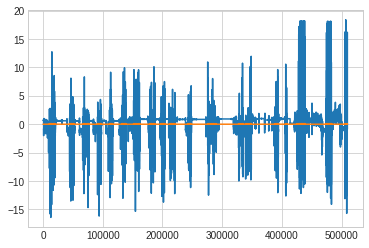

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, dfNorm.shape[0])
ax.plot(dfNorm['v1'])
ax.plot(labels['label']/10)

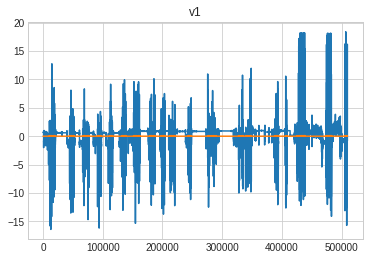

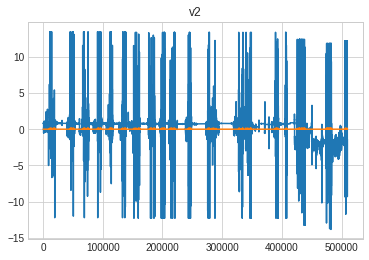

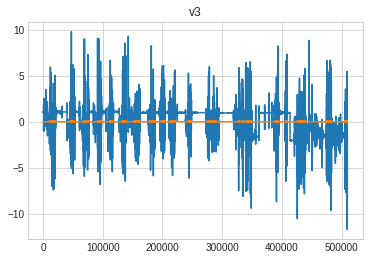

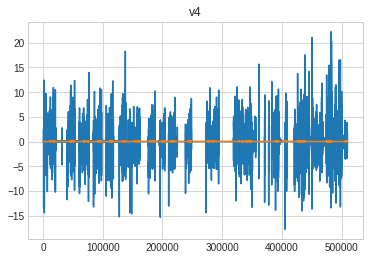

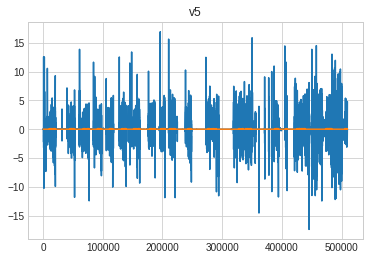

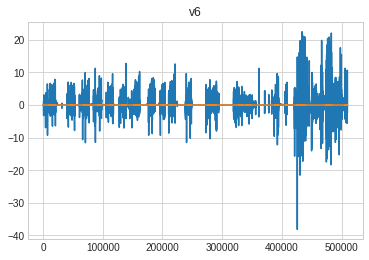

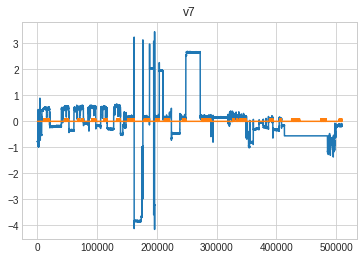

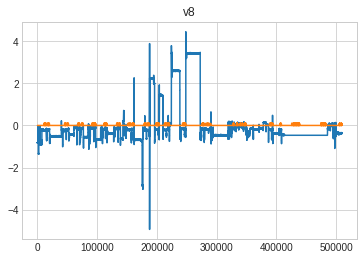

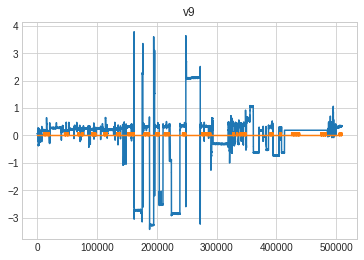

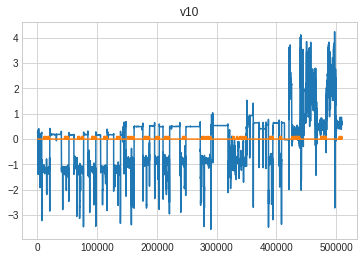

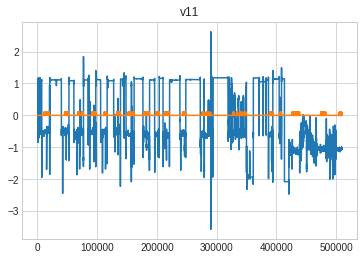

In [10]:
for col in dfNorm.columns:
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)

    x = np.linspace(0, dfNorm.shape[0])
    ax.plot(dfNorm[col])
    ax.plot(labels['label']/10)
    

### Note that ONE event is actually a TIME SERIES of events around it

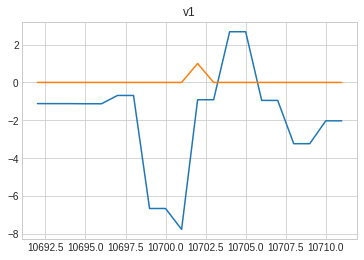

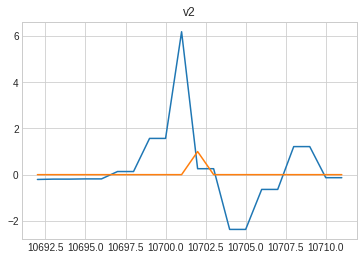

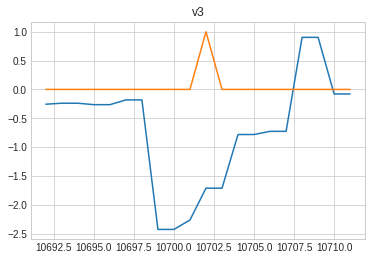

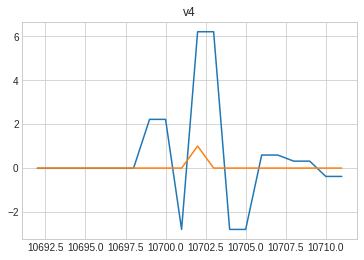

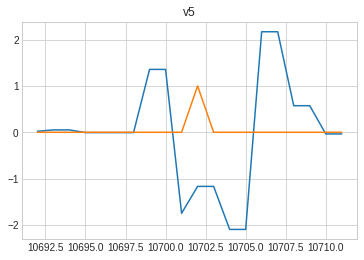

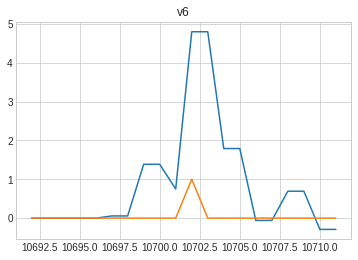

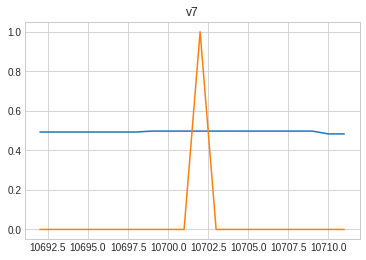

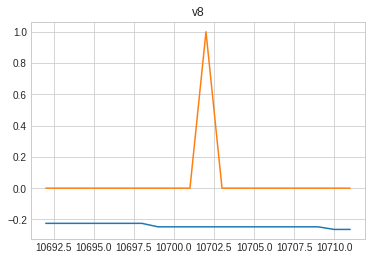

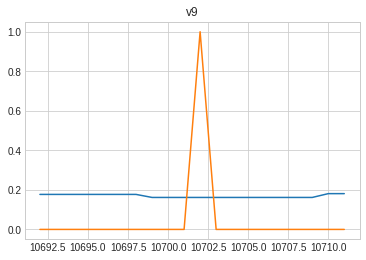

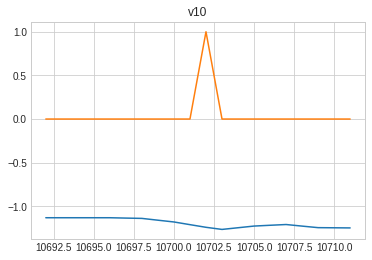

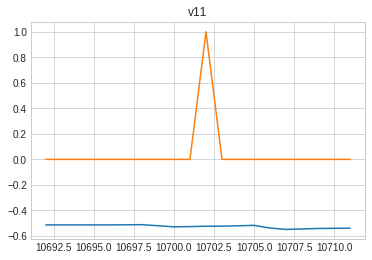

In [11]:
# Some viz of normalized data ONE EVENT

eventRow = 10702

minX = eventRow - 10
maxX = eventRow + 10

for col in dfNorm.columns:
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    
    x = np.linspace(minX, maxX)
    ax.plot(dfNorm[col][minX:maxX])
    ax.plot(labels['label'][minX:maxX])

Seems that v7-v11 don't change much during ONE event...let's check the stats on no-event vs events

In [12]:
dfNorm['label'] = labels['label']
dfNorm.shape

(509632, 12)

In [13]:
NoEvent = dfNorm[dfNorm['label'] == 0]
OnlyEvent = dfNorm[dfNorm['label'] == 1]
print(NoEvent.shape)
print(OnlyEvent.shape)

(509189, 12)
(443, 12)


In [14]:
NoEvent.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,label
count,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.000000,509189.0
mean,-0.001927,0.001269,0.000978,-0.001227,0.000630,-0.002526,-0.000107,0.000169,-0.000244,0.000654,0.000559,0.0
std,0.987096,0.993215,0.997711,0.992361,0.998134,0.985244,1.000379,1.000409,1.000399,1.000040,1.000236,0.0
min,-16.406174,-13.819733,-11.707532,-17.809165,-17.387542,-21.526124,-4.155051,-4.937219,-3.428929,-3.563101,-3.574645,0.0
25%,-0.852703,-0.278488,-0.409339,-0.008859,-0.007162,-0.002601,-0.465134,-0.467247,0.021817,-0.819958,-0.629221,0.0
50%,0.486715,0.043495,-0.236828,-0.008859,-0.007162,-0.002601,0.040918,-0.222194,0.203160,0.185306,-0.506771,0.0
75%,0.850616,0.764278,0.986435,-0.008859,0.021854,-0.002601,0.229171,-0.125316,0.318935,0.530156,1.111383,0.0
max,18.385811,13.439276,9.788439,22.241523,16.908968,22.504524,3.443955,4.449259,3.787493,4.236150,2.620674,0.0


In [15]:
OnlyEvent.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,label
count,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.0
mean,2.215370,-1.458656,-1.124175,1.410670,-0.724562,2.903015,0.123540,-0.194161,0.280128,-0.751465,-0.642745,1.0
std,5.061735,3.801298,2.237031,4.067205,2.184895,5.128038,0.338815,0.153361,0.082986,0.589067,0.216109,0.0
min,-4.647355,-12.940410,-10.535238,-14.054413,-7.464186,-38.189497,-0.558021,-0.467247,0.125013,-1.491480,-1.219525,1.0
25%,-0.982041,-1.797690,-2.183463,-0.727361,-2.197844,-0.002601,0.056182,-0.231928,0.191583,-1.122395,-0.625563,1.0
50%,0.622630,-0.701805,-1.079782,1.428144,-0.935663,2.427474,0.137328,-0.188974,0.291884,-0.921443,-0.568780,1.0
75%,3.381480,0.222465,-0.047980,3.792247,0.631183,5.551857,0.455127,-0.139222,0.338193,-0.796984,-0.512171,1.0
max,18.385811,12.182400,6.696302,18.486771,6.115143,19.785154,0.641032,0.148630,0.455972,1.335982,-0.286779,1.0


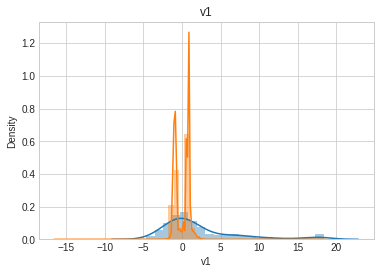

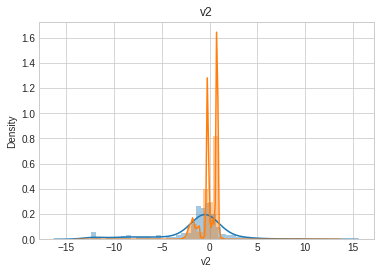

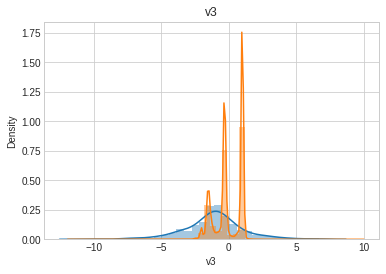

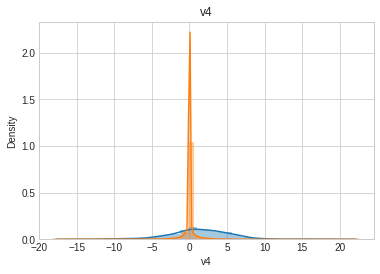

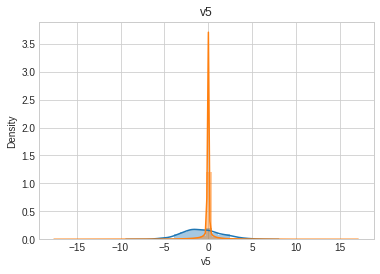

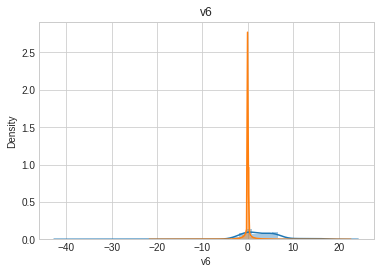

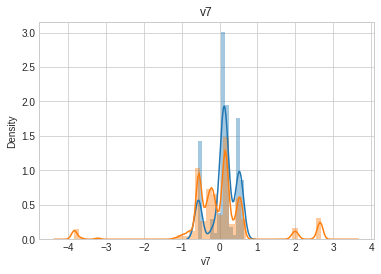

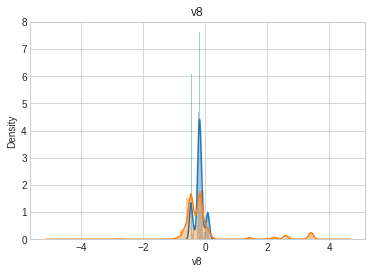

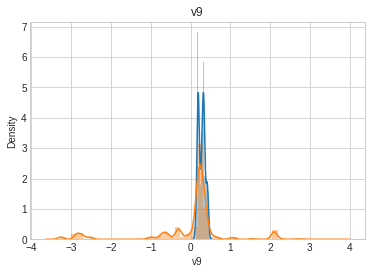

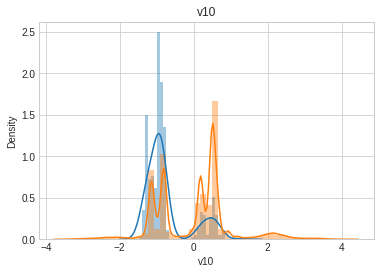

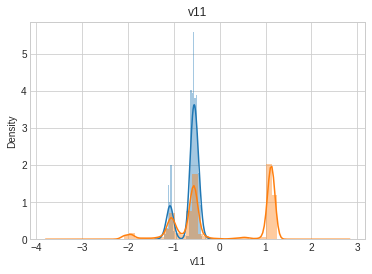

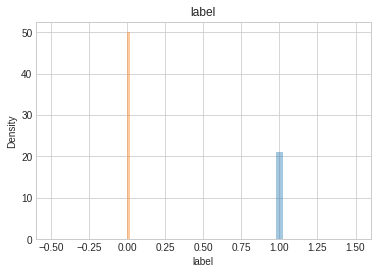

In [16]:
# Viz the distribution of each feature: no-event vs event

for col in dfNorm.columns:
    plt.figure()
    sns.distplot(OnlyEvent[col]).set_title(col)
    sns.distplot(NoEvent[col])


In [17]:
# As the above dist differences between event and no-event may be because of the size differences...
# Repeat the above with a sample of the same size for no-event ... downsample

NoEventSample = NoEvent.sample(443)
NoEventSample.shape

(443, 12)

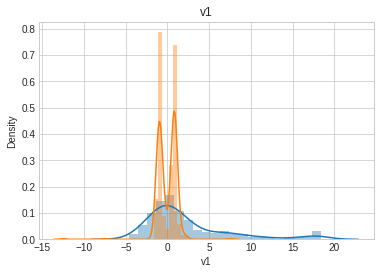

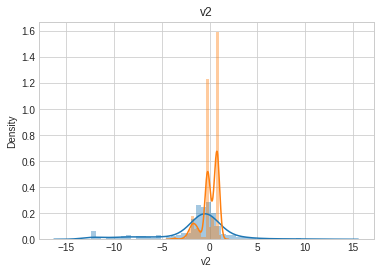

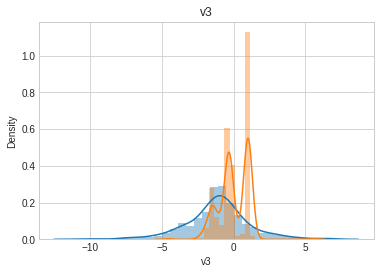

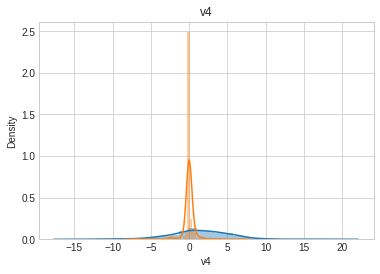

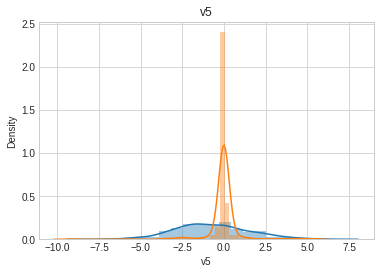

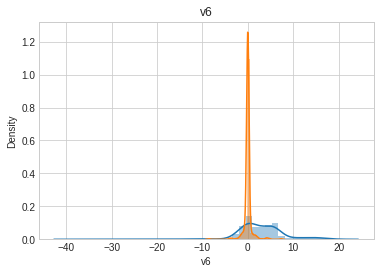

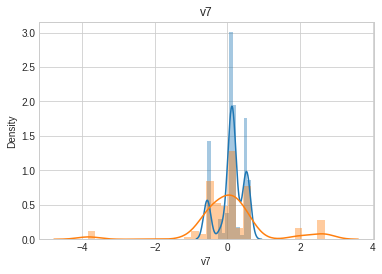

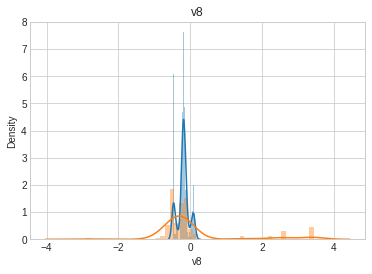

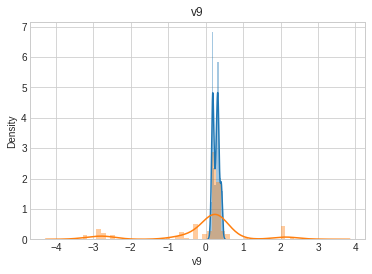

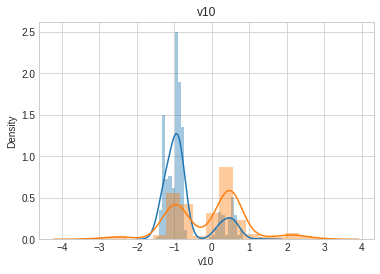

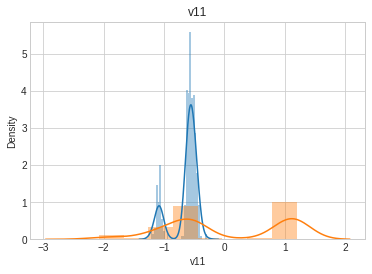

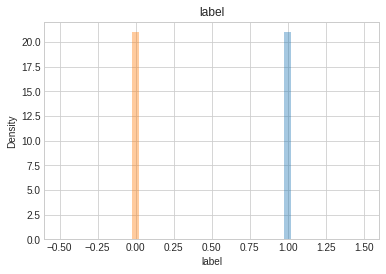

In [18]:
# Viz the distribution of each feature: no event vs event - SAME size

for col in dfNorm.columns:
    plt.figure()
    sns.distplot(OnlyEvent[col],fit_kws={"color":"red"}).set_title(col)
    sns.distplot(NoEventSample[col])

### Multi-variate Gaussian probability density function - as the baseline

### Split into train and test

#As v7-v11 do not change much during an event - I removed them, to see if it improves performance ...It does NOT

NoEvent = dfNorm[dfNorm['label'] == 0]
OnlyEvent = dfNorm[dfNorm['label'] == 1]
print(NoEvent.shape)
print(OnlyEvent.shape)

NoEvent.drop(['v7','v8','v9', 'v10', 'v11'], axis=1, inplace=True)
OnlyEvent.drop(['v7','v8','v9', 'v10', 'v11'], axis=1, inplace=True)
print(NoEvent.shape)
print(OnlyEvent.shape)


In [19]:
print(NoEvent.shape)
print(OnlyEvent.shape)

Cols = list(NoEvent)[:-1] 
NoEvent = NoEvent[Cols]
OnlyEvent = OnlyEvent[Cols]
print(NoEvent.shape)
print(OnlyEvent.shape)

(509189, 12)
(443, 12)
(509189, 11)
(443, 11)


In [20]:
# CREATE the TRAIN and TEST sets
# Anom data is ONLY in TEST - not in TRAIN

num_test = 100000
shuffled_data = NoEvent.sample(frac=1, random_state=47)[:-num_test].values
X_train = shuffled_data

#X_valid = np.concatenate([shuffled_data[-2*num_test:-num_test], fraud_pca_data[:246]])
#y_valid = np.concatenate([np.zeros(num_test), np.ones(246)])

X_test = np.concatenate([shuffled_data[-num_test:], OnlyEvent[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(OnlyEvent.shape[0])])

print("normal ", dfNorm.shape)
print("OnlyEvents", OnlyEvent.shape)
print("OnlyEvents data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal  (509632, 12)
OnlyEvents (443, 11)
OnlyEvents data only in Test with NONE in the training
X_train  (409189, 11)
X_test  (100443, 11)
y_test  (100443,)


In [21]:

p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

x = p.pdf(X_train) 
probNorm = x / x.sum() # Normalize pdf
print("max prob of x on X_train", max(probNorm))
print("mean prob of x on X_train", np.mean(probNorm))
print('-' * 60)
MyTrain = np.mean(probNorm)

x = p.pdf(X_test) 
probNorm = x / x.sum() # Normalize pdf
print("max prob of x on X_test", max(probNorm))
print("mean prob of x on X_test", np.mean(probNorm))
print('-' * 60)
MyTest = np.mean(probNorm)

x = p.pdf(OnlyEvent) 
probNorm = x / x.sum() # Normalize pdf
print("max prob of x on OnlyEvent", max(probNorm))
print("mean prob of x on OnlyEvent", np.mean(probNorm))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)

max prob of x on X_train 7.542779528167279e-06
mean prob of x on X_train 2.443858461493344e-06
------------------------------------------------------------
max prob of x on X_test 3.087037029140375e-05
mean prob of x on X_test 9.95589538345131e-06
------------------------------------------------------------
max prob of x on OnlyEvent 0.7707216579692563
mean prob of x on OnlyEvent 0.002257336343115125
------------------------------------------------------------
Difference between mean prob of Train vs Test  -7.512036921957967e-06


In [22]:
# Find best epsilon re F1 score

x = p.pdf(X_test)
x = x / x.sum() # Normalize pdf

EpsF1 = []


epsilons = [1e-5, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30,1e-35, 1e-40, 1e-45, 1e-50, 1e-55, 1e-60, 1e-65, 1e-70, 1e-75, 1e-80, 1e-85, 1e-90]


for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head(20)

,epsilon,F1
0,1.000000e-05,0.0170
1,1.000000e-10,0.1077
2,1.000000e-15,0.1994
3,1.000000e-20,0.2576
4,1.000000e-25,0.2840
5,1.000000e-30,0.2954
6,1.000000e-35,0.3049
7,1.000000e-40,0.3115
8,1.000000e-45,0.3124
9,1.000000e-50,0.3009


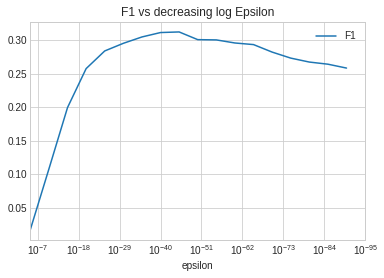

In [23]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-5, 1e-95)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

# Time series approach

* Create periods of 9 time steps labeled as NoEvent or OnlyEvent
* Events are in the middle (there are 4 rows before and 4 after) of the time period, and the chunk is labeled as OnlyEvent
* No-events time periods have no event within their 9 time steps, labeled NoEvent
* So the algorithm would hopefully be able to separate the events

In [24]:
# Identify the row where event
EventsRows = dfNorm.index[dfNorm['label'] == 1]
len(EventsRows)


443

In [25]:
# Returns minimum difference between any pair 
def findMinDiff(arr, n): 
    # Initialize difference as infinite 
    diff = 10**20
      
    # Find the min diff by comparing difference 
    # of all possible pairs in given array 
    for i in range(n-1): 
        for j in range(i+1,n): 
            if abs(arr[i]-arr[j]) < diff: 
                diff = abs(arr[i] - arr[j]) 
  
    # Return min diff 
    return diff 

In [26]:
n = len(EventsRows) 
print("Minimum difference between events is " + str(findMinDiff(EventsRows, n)),'time steps')

Minimum difference between events is 15 time steps


### Chunk into buckets the NoEvent and OnlyEvent ... chunk size = 9 time steps

In [27]:
def chunk(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


In [28]:
ChunkCounter = 0
result_arrList = []
chunkSize = 9

for df_chunk in chunk(dfNorm, chunkSize):
    if df_chunk.label.any() == 1 or df_chunk.shape[0] < chunkSize:
        pass
    else:
        result_arrList.append(df_chunk.iloc[:,:-1])
        ChunkCounter = ChunkCounter + 1
        #print(df_chunk)
    
ChunkCounter

56182

In [29]:
# No-event 56k periods - chunks of 9 time steps and 11 features each:

NoEvent_arr = np.stack(result_arrList, axis=0)
NoEvent_arr.shape

(56182, 9, 11)

In [30]:
# For the OnlyEvent chunking

idx = dfNorm.index.get_indexer_for(dfNorm[dfNorm.label == 1].index)
print(idx.shape)

n=4

OnlyEvent_arr = dfNorm.iloc[np.unique(np.concatenate([np.arange(max(i-n,0), min(i+n+1, len(dfNorm)))
                                            for i in idx]))]

pd.options.display.max_rows = 100
OnlyEvent_arr.head(100)

(443,)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,label
10698,-0.688290,0.135023,-0.181938,-0.008859,-0.007162,0.055258,0.492700,-0.224975,0.177111,-1.138047,-0.511474,0
10699,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.158748,-0.519835,0
10700,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.178944,-0.528369,0
10701,-7.762434,6.190583,-2.263837,-2.790157,-1.748101,0.749565,0.497396,-0.247224,0.161749,-1.209743,-0.526453,0
10702,-0.914084,0.257605,-1.712324,6.202706,-1.167788,4.799691,0.497396,-0.247224,0.161749,-1.240038,-0.523492,1
10703,-0.914084,0.257605,-1.712324,6.202706,-1.167788,4.799691,0.497396,-0.247224,0.161749,-1.264273,-0.523492,0
10704,2.676696,-2.372191,-0.781807,-2.790157,-2.096289,1.791026,0.497396,-0.247224,0.161749,-1.245087,-0.520183,0
10705,2.676696,-2.372191,-0.781807,-2.790157,-2.096289,1.791026,0.497396,-0.247224,0.161749,-1.225900,-0.516699,0
10706,-0.949159,-0.639696,-0.726917,0.593755,2.169013,-0.060460,0.497396,-0.247224,0.161749,-1.216812,-0.538124,0
11420,-8.045224,13.439276,-1.159503,-1.167734,0.805277,-0.754767,0.516313,-0.258195,0.192473,-1.184498,-0.531331,0


In [31]:
# After checking the event label is in the middle of each OnlyEvent period, remove the label and make an array of chunks

OnlyEvent_arr = OnlyEvent_arr.iloc[:,:-1]
OnlyEvent_arr.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
10698,-0.688290,0.135023,-0.181938,-0.008859,-0.007162,0.055258,0.492700,-0.224975,0.177111,-1.138047,-0.511474
10699,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.158748,-0.519835
10700,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.178944,-0.528369
10701,-7.762434,6.190583,-2.263837,-2.790157,-1.748101,0.749565,0.497396,-0.247224,0.161749,-1.209743,-0.526453
10702,-0.914084,0.257605,-1.712324,6.202706,-1.167788,4.799691,0.497396,-0.247224,0.161749,-1.240038,-0.523492


In [32]:
ChunkCounter = 0
result_arrList = []
chunkSize = 9

for df_chunk in chunk(OnlyEvent_arr, chunkSize):
    if df_chunk.shape[0] < chunkSize:
        pass
    else:
        result_arrList.append(df_chunk)
        ChunkCounter = ChunkCounter + 1
        #print(df_chunk)
    
ChunkCounter

443

In [33]:
# OnlyEvent 443 periods - chunks of 9 time steps and 11 features each:

OnlyEvent_arr = np.stack(result_arrList, axis=0)
OnlyEvent_arr.shape

(443, 9, 11)

### Now the anomaly prob is 443 / 56,182 = 0.79% ... much easier, about 9 times easier for the model...

In [34]:
# Concatenate the 2 arrays before split into train and test

AllFeat_arr = np.append(NoEvent_arr, OnlyEvent_arr, axis = 0)
AllFeat_arr.shape


(56625, 9, 11)

In [35]:
# Create the label ... y

y0 = np.zeros(NoEvent_arr.shape[0])

y1 = np.ones(OnlyEvent_arr.shape[0])

y = np.append(y0, y1, axis = 0)
y.shape

(56625,)

### 56k samples, each has 9 time steps and 11 features (56k tables of 9 rows X 11 cols)

In [36]:
# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(AllFeat_arr, y, test_size=0.2, random_state=7)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (45300, 9, 11)
X_test:  (11325, 9, 11)
y_train:  (45300,)
y_test:  (11325,)


Excellent overview https://towardsdatascience.com/time-series-forecasting-with-2d-convolutions-4f1a0f33dff6

In [37]:
# We have to redimension the arrays for the Conv2D digestion benefit

data_train_wide = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
data_test_wide = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(data_train_wide.shape)
print(data_test_wide.shape)

(45300, 9, 11, 1)
(11325, 9, 11, 1)


# Conv2D NN

### Baseline accuracy by majority voting = 100 - 0.79% = 99.21%

In [38]:
# F1 function as there is none in Keras metrics

#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [39]:
# NN model

n_filters = 64
fsize = 5  # Note that kernel size (1, fsize) = it is not a square kernel...it is rectangular
window_size = 9   # Number of time steps in one period
n_features = 11 # Number of cols in one sample (one table)


MyModel = models.Sequential()
MyModel.add(layers.Conv2D(n_filters, fsize, activation='relu', input_shape=(window_size, n_features, 1)))
MyModel.add(layers.Flatten())
MyModel.add(layers.Dense(256, activation='relu'))
#MyModel.add(layers.Dropout(0.2))

MyModel.add(layers.Dense(1, activation='sigmoid'))

MyModel.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss='binary_crossentropy', 
              metrics=[get_f1])
              #metrics=['binary_accuracy'])

print(MyModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 7, 64)          1664      
_________________________________________________________________
flatten (Flatten)            (None, 2240)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               573696    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 575,617
Trainable params: 575,617
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Train / fit

history = MyModel.fit(data_train_wide, y_train, 
                      validation_split=0.2, 
                      epochs = 20, 
                      batch_size = 16)


Epoch 1/20
2265/2265 [==============================] - 16s 7ms/step - loss: 0.0580 - get_f1: 0.0655 - val_loss: 0.0033 - val_get_f1: 0.0823
Epoch 2/20
2265/2265 [==============================] - 13s 6ms/step - loss: 0.0025 - get_f1: 0.1067 - val_loss: 0.0051 - val_get_f1: 0.0705
Epoch 3/20
2265/2265 [==============================] - 13s 6ms/step - loss: 0.0014 - get_f1: 0.1175 - val_loss: 0.0029 - val_get_f1: 0.0858
Epoch 4/20
2265/2265 [==============================] - 13s 6ms/step - loss: 0.0012 - get_f1: 0.1283 - val_loss: 0.0030 - val_get_f1: 0.0847
Epoch 5/20
2265/2265 [==============================] - 13s 6ms/step - loss: 0.0011 - get_f1: 0.1325 - val_loss: 0.0025 - val_get_f1: 0.0864
Epoch 6/20
2265/2265 [==============================] - 14s 6ms/step - loss: 4.3332e-04 - get_f1: 0.1245 - val_loss: 0.0036 - val_get_f1: 0.0794
Epoch 7/20
2265/2265 [==============================] - 13s 6ms/step - loss: 2.1208e-04 - get_f1: 0.1324 - val_loss: 0.0051 - val_get_f1: 0.0776
Epoch

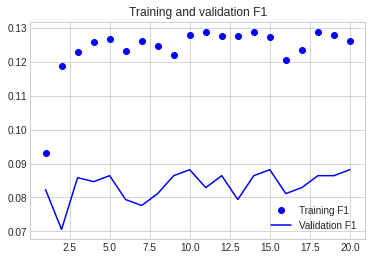

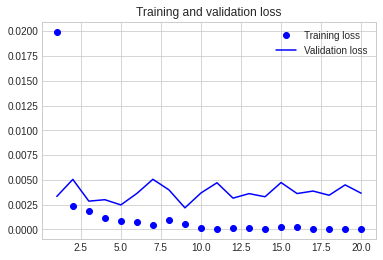

In [41]:
#Learning curves ... F1

acc = history.history['get_f1'] 
val_acc = history.history['val_get_f1'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training F1') 
plt.plot(epochs, val_acc, 'b', label='Validation F1') 
plt.title('Training and validation F1') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()

#Learning curves ... Binary accuracy

acc = history.history['binary_accuracy'] 
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()

In [42]:
# Final Predict
# NOTE final_predictions is a list of probabilities

final_predictions = MyModel.predict(data_test_wide)
final_predictions.shape

(11325, 1)

In [43]:
# Modify the raw final_predictions - prediction probs into 0 and 1

Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

Preds.shape

(11325, 1)

In [44]:
# Confusion matrix

from sklearn import metrics
conf_mx = metrics.confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  11242
FP:  0
FN:  2
TP:  81
0.9759036144578314 1.0


In [45]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

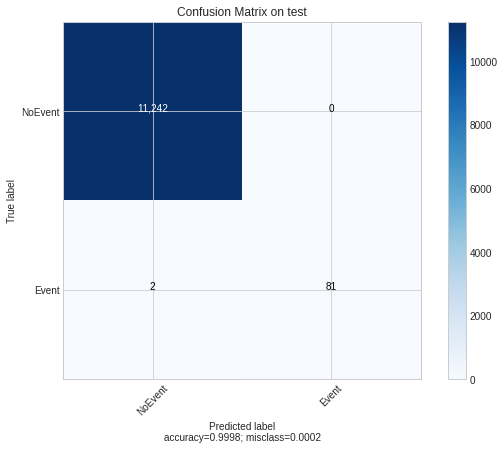

In [46]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['NoEvent', 'Event'],
                      title        = "Confusion Matrix on test")

f1=0.988


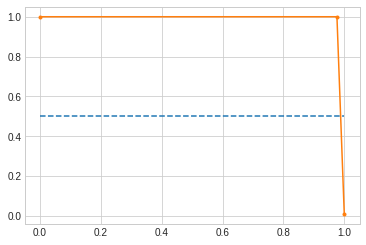

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = metrics.f1_score(y_test, Preds)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

# Results

Adam(lr=1e-4) , batch size = 16, optimized on get_f1, square kernel size = (fsize, fsize) = fsize, 20 epochs

* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, fsize=2  ... F1 = 0.975
* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, fsize=3  ... F1 = 0.982
* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, fsize=4  ... F1 = **0.988**
* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, fsize=5  ... F1 = 0.988
* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, fsize=6  ... F1 = 0.988
* Conv2D 64 filters, Flatten, Dense 256, Dropout 0.2, Sigmoid, fsize=5  ... F1 = 0.976
* Conv2D 64 filters, Flatten, Dense 256, Dropout 0.2, Sigmoid, rectangular kernel size = (1, 5)   ... F1 = 0.982


* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, 20 epochs, optimized on get_f1 ... F1 = 0.982
* Conv2D 64 filters, Flatten, Dense 256, Sigmoid, 20 epochs, optimized on binary_acc ... F1 = 0.956
* Conv2D 64 filters, Flatten, Sigmoid, 50 epochs ... F1 = 0.91


# Plan for further experimentations

* Check various lr, pooling after Conv2D instead of Flatten, w/without GRU after Conv2D
* Under, oversampling, SMOTE, ADASYN
